## Image Embedding
method: 
1. ViT
2. GCN 
3. GAT
input: image 
output: embedding of patches of image (16 patches) output shape: (N, 16, )

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv,GATConv
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random
import math
import transformers
from transformers import GPT2Tokenizer
from transformers import BertTokenizer
from tqdm import tqdm
from sacrebleu.metrics import BLEU
from sacrebleu import corpus_bleu
from collections import defaultdict
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("working on ", device)

working on  cuda


### predefined MAX length and Batch size

In [3]:
MAX_LENGTH = 30
BATCH_SIZE = 64

### predefine data transform

In [4]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


### load GPT-2 Tokenizer

In [5]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
VOCAB_SIZE = tokenizer.vocab_size


## Data fetching

### Load Ficker8k dataset

In [11]:
image_path = "./Images"
caption_path = "./captions.txt"

In [12]:
def parse_captions(txt_path):
    '''
        input: caption path
        return: a dictionary, key: image names; value: caption
    '''
    captions_dict = defaultdict(list)
    with open(txt_path, 'r') as f:
        next(f)  # 跳过标题行
        for line in f:
            line = line.strip()
            if not line:
                continue
            # 假设每行格式：图片名\tcaption
            parts = line.split(',')
            if len(parts) >= 2:
                img_name, caption = parts[0], parts[1]
                captions_dict[img_name].append(caption)
    return captions_dict

In [13]:
def split_dataset(captions_dict, ratios=(0.6, 0.2, 0.2), seed=42):
    '''
        split dataset with ratio
        input ratio sample: (0.6,0.2,0.2)
        return: (train, val,test)
    '''
    assert sum(ratios) == 1.0, "sum of ratios must be one"
    img_names = list(captions_dict.keys())
    random.seed(seed)
    random.shuffle(img_names)
    
    total = len(img_names)
    train_end = int(ratios[0] * total)
    val_end = train_end + int(ratios[1] * total)
    
    return (
        img_names[:train_end],
        img_names[train_end:val_end],
        img_names[val_end:]
    )

In [14]:
class Flickr8kDataset(Dataset):
    def __init__(self, img_dir, captions_dict, img_list, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.samples = []
        
        # 构建样本列表 (图片路径, caption)
        for img_name in img_list:
            img_path = os.path.join(img_dir, img_name)
            if os.path.exists(img_path):  # 确保图片存在
                for caption in captions_dict.get(img_name, []):
                    self.samples.append((img_path, caption))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, caption = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, caption

In [15]:
def collate_fn(batch):
    """自定义批次处理函数"""
    images, texts = zip(*batch)
    
    # 图像处理
    images = torch.stack(images, dim=0)
    
    # 文本编码
    text_encodings = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors='pt',
        add_special_tokens=True

    )
    attention_mask = text_encodings['attention_mask'].squeeze()
    pad_mask = (attention_mask == 0)
    return {
        'image': images,
        'input_ids': text_encodings['input_ids'],
        'attention_mask': pad_mask
    }

In [16]:
captions_dict = parse_captions(caption_path)
train_list, val_list, test_list = split_dataset(captions_dict)


In [22]:
len(train_list)

4854

In [23]:
len(val_list)

1618

In [24]:
len(test_list)

1619

In [17]:
train_dataset = Flickr8kDataset(
        image_path, captions_dict, train_list, transform=transform
)
val_dataset = Flickr8kDataset(
    image_path, captions_dict, val_list, transform=transform
)
test_dataset = Flickr8kDataset(
    image_path, captions_dict, test_list, transform=transform
)

In [21]:
len(train_dataset)

24270

In [13]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

### Load COCO dataset

In [6]:
train_coco_dir = "./train2014"
val_coco_dir = "./val2014"
# test_image_dir = "/path/to/coco-2017/test/images"

coco_train_annos = "./annotations/captions_train2014.json"
coco_val_annos = "./annotations/captions_val2014.json"
# test_annotations = "/path/to/coco-2017/annotations/captions_test2017.json"

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
Caption: A girl feeds giraffes through a fence at the zoo.
Caption: a girl feeds a giraffe through a fence
Caption: A child feeds giraffes through a mesh wire fence
Caption: A little girl trying to feed two giraffes through a netted barrier.
Caption: Young girl feeding the giraffes through the mesh fencing. 


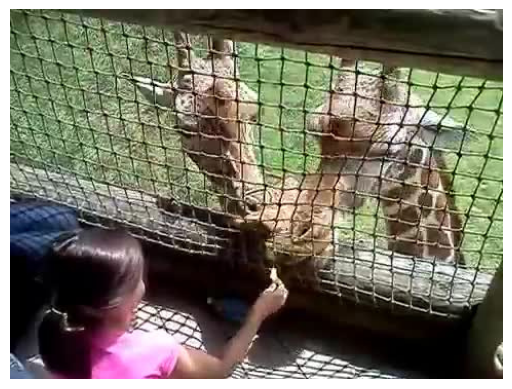

In [7]:
coco = COCO(coco_train_annos)

# Get a random image ID
image_ids = list(coco.imgs.keys())
random_img_id = random.choice(image_ids)

# Load image metadata
img_info = coco.loadImgs(random_img_id)[0]
img_path = os.path.join(train_coco_dir, img_info["file_name"])

# Load and display the image
image = Image.open(img_path)
plt.imshow(image)
plt.axis("off")  # Hide axes

# Get captions for the image
ann_ids = coco.getAnnIds(imgIds=random_img_id)
annotations = coco.loadAnns(ann_ids)

# Print the first few captions
for ann in annotations:
    print("Caption:", ann["caption"])

# Show the image
plt.show()

#### COCO Dataset for loading data

In [8]:



class COCODataset(Dataset):
    def __init__(self, image_dir, annotation_file, max_length = MAX_LENGTH, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.max_length = max_length

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        
        # Get image path
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Get the first caption (you can modify this for multiple captions)
        caption = annotations[0]['caption'] if annotations else ""

        encoding = tokenizer(
            caption, 
            max_length = self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        attention_mask = encoding['attention_mask'].squeeze()
        pad_mask = (attention_mask == 0)
        return {
            'image':image,
            'input_ids':encoding['input_ids'].squeeze(),
            'attention_mask': pad_mask
        }


In [9]:


coco_test_dataset = COCODataset(val_coco_dir, coco_val_annos, transform=transform)
# test_dataset = COCODataset(test_image_dir, test_annotations, transform=transform)

coco_test_loader = DataLoader(coco_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


In [10]:
len(coco_test_dataset)

40504

In [61]:
sample_batch = next(iter(coco_test_loader))
print("shape of images:", sample_batch['image'].shape)  # 应输出 (32, 3, 224, 224)
print("shape of input ids:", sample_batch['input_ids'].shape)  # 应输出 (32, seq_len)
print("shape of attention mask:", sample_batch['attention_mask'])  # 应输出 (32, seq_len)

shape of images: torch.Size([64, 3, 224, 224])
shape of input ids: torch.Size([64, 30])
shape of attention mask: tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])


### Model Architecture
Three Encoders: 
1. CNN + GAT
2. CNN + GCN
3. ViT Encoder

In [19]:
'''
1. attention head
2. VIT_encoder (use attention head) doesn't need [CLS] token use pixels as feature vectores
3. decoder: transformer decoder
4. GCN_encoder input: image: 16 patches -> 16 nodes with adjecency matrix; output -> each patch has an encoding as k and v
5. GAT_encoder : same as GCN 

need to get adjecency matrix of image nodes
'''

"\n1. attention head\n2. VIT_encoder (use attention head) doesn't need [CLS] token use pixels as feature vectores\n3. decoder: transformer decoder\n4. GCN_encoder input: image: 16 patches -> 16 nodes with adjecency matrix; output -> each patch has an encoding as k and v\n5. GAT_encoder : same as GCN \n\nneed to get adjecency matrix of image nodes\n"

In [14]:

class ViT_Encoder(nn.Module):
    def __init__(self, 
                 img_size=224, 
                 num_patches=16, 
                 in_channels=3, 
                 dim=128,
                 use_sin_pe=True, 
                 depth=12, 
                 heads=8, 
                 mlp_dim=1024, 
                 dropout=0.1, 
                 activation='gelu'):
        super(ViT_Encoder, self).__init__()
        
        # check initialization parameters
        assert dim % 2 == 0, "dim must be an even number"
        sqrt_n = int(math.sqrt(num_patches))
        assert sqrt_n ** 2 == num_patches, "num_patches must be a square number"
        
        self.img_size = img_size
        self.num_patches = num_patches
        self.patch_size = img_size // sqrt_n
        self.use_sin_pe = use_sin_pe
        self.dim = dim
        
        patch_dim = in_channels * self.patch_size ** 2
        self.patch_embedding = nn.Linear(patch_dim, dim)

        # positional Encoding
        if use_sin_pe:
            self.register_buffer(
                'position_embedding',
                self.create_sin_positional_encoding(num_patches, dim)
            )
        else:
            self.position_embedding = nn.Parameter(
                torch.randn(num_patches, dim)  #  [1, N, D]
            )
        
        # Transformer layer
        valid_activations = ['gelu', 'relu', 'tanh']
        assert activation in valid_activations, f"non-support activation : {activation}"
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim,
            nhead=heads,
            dim_feedforward=mlp_dim,
            dropout=dropout,
            activation=activation
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

    def create_sin_positional_encoding(self, num_patches, dim):
        """Sin positional encoding"""
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        position = torch.arange(num_patches, device=device).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, dim, 2, device=device).float() * 
            (-math.log(10000.0) / dim)
        )
        pe = torch.zeros(num_patches, dim, device=device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe  # (num_patches, dim)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        assert height == self.img_size and width == self.img_size, \
            f"input size ({height}x{width}) doesn't match initialization size ({self.img_size}x{self.img_size})"
        
        # 分块处理
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).contiguous()
        x = x.view(batch_size, self.num_patches, -1)
        
        # projection & positional encoding
        x = self.patch_embedding(x)  # (B, N, D)
        x = x * math.sqrt(self.dim) # can consider to delete this line
        x = x + self.position_embedding  
        
        # Transformer process
        x = x.permute(1, 0, 2)  # (N, B, D)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # (B, N, D)
        return x

# Instantiate the ViT model
model = ViT_Encoder(img_size=224, num_patches=16, use_sin_pe=False).to(device)  # For example, 10 classes
print(model)


ViT_Encoder(
  (patch_embedding): Linear(in_features=9408, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
)


c:\Users\mikew\miniconda3\envs\venv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [15]:
x = torch.randn(32, 3, 224, 224).to(device)
print(model(x).shape)

torch.Size([32, 16, 128])


In [16]:
class GCN_Encoder(nn.Module):
    def __init__(self,
                 img_size=224,
                 num_patches = 16,
                 in_channels=3,
                 encode_dim=128,
                 use_sin_pe=True,
                 gcn_layers=3,
                 hidden_dim=128):
        super(GCN_Encoder,self).__init__()
        # 参数验证
        sqrt_n = int(math.sqrt(num_patches))
        assert sqrt_n ** 2 == num_patches, "num_patches必须为平方数"
        assert img_size % sqrt_n == 0, "img_size必须能被sqrt(num_patches)整除"
        
        self.num_patches = num_patches
        self.img_size = img_size
        
        self.patch_size = img_size // sqrt_n
        self.encode_dim = encode_dim
        self.hidden_dim = hidden_dim
        
        # 分块参数计算
        patch_dim = in_channels * (self.patch_size ** 2)
        
        # 节点特征投影
        self.patch_embed = nn.Linear(patch_dim, hidden_dim)
        
        # 位置编码
        if use_sin_pe:
            self.register_buffer(
                'position_embedding',
                self.create_sin_positional_encoding(self.num_patches, hidden_dim)
            )
        else:
            self.position_embedding = nn.Parameter(
                torch.randn(self.num_patches, hidden_dim)
            )
        
        # GCN层
        self.convs = nn.ModuleList()
        # TODO: potential optimization: adding batch norm or layer norm 
        for _ in range(gcn_layers):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
        
        # 输出投影
        self.proj_out = nn.Linear(hidden_dim, encode_dim)
        # TODO: potential optimization: adding Xavier initialization
        
        # 预计算边索引
        self.edge_index = self.create_spatial_edges()

    def create_sin_positional_encoding(self, num_patches, dim):
        """创建正弦位置编码"""
        device = next(self.parameters()).device
        position = torch.arange(num_patches, device=device).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, dim, 2, device=device).float() * 
            (-math.log(10000.0) / dim))
        pe = torch.zeros(num_patches, dim, device=device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def create_spatial_edges(self):
        """创建基于空间位置的边连接"""
        edge_list = []
        grid_size = int(math.sqrt(self.num_patches))  # 4x4网格
        
        for i in range(grid_size):
            for j in range(grid_size):
                current = i * grid_size + j
                # 连接右邻居
                if j < grid_size - 1:
                    edge_list.append([current, current + 1])
                # 连接下邻居
                if i < grid_size - 1:
                    edge_list.append([current, current + grid_size])
        
        # 添加双向边
        edge_index = torch.tensor(edge_list).t().contiguous()
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # 双向连接
        return edge_index

    def forward(self, x):
        """
        输入: (batch_size, channels, height, width)
        输出: (batch_size, num_patches, encode_dim)
        """
        # Step 1: 分块处理
        batch_size = x.shape[0]
        x = x.unfold(2, self.patch_size, self.patch_size)  # (B, C, H/p, W/p, p)
        x = x.unfold(3, self.patch_size, self.patch_size)  # (B, C, H/p, W/p, p, p)
        x = x.permute(0, 2, 3, 1, 4, 5)  # (B, H/p, W/p, C, p, p)
        x = x.reshape(batch_size, self.num_patches, -1)  # (B, 16, C*p*p)
        
        # Step 2: 节点特征嵌入
        x = self.patch_embed(x)  # (B, 16, hidden_dim)
        
        # Step 3: 添加位置编码
        pos_embed = self.position_embedding.unsqueeze(0)  # (1, 16, hidden_dim)
        # TODO: potential optimization: scale up x by sqrt(dim)
        x = x + pos_embed
        
        # Step 4: 转换到图结构
        data_list = []
        for i in range(batch_size):
            data = Data(
                x=x[i], 
                edge_index=self.edge_index.to(x.device)
            )
            data_list.append(data)
        batch_data = Batch.from_data_list(data_list)
        x = batch_data.x
        # Step 5: 应用GCN层
        for conv in self.convs:
            #TODO: potential optimization: adding norm layer
            x = F.relu(conv(x, batch_data.edge_index))
        
        # Step 6: 恢复形状并投影
        x = x.view(batch_size, self.num_patches, self.hidden_dim)  # (B, 16, hidden_dim)
        x = self.proj_out(x)  # (B, 16, encode_dim)
        
        return x

In [17]:
model = GCN_Encoder(img_size=224, num_patches=16).to(device)  # For example, 10 classes
print(model)
x = torch.randn(32, 3, 224, 224).to(device)
print(model(x).shape)

GCN_Encoder(
  (patch_embed): Linear(in_features=9408, out_features=128, bias=True)
  (convs): ModuleList(
    (0-2): 3 x GCNConv(128, 128)
  )
  (proj_out): Linear(in_features=128, out_features=128, bias=True)
)
torch.Size([32, 16, 128])


In [18]:
class GAT_Encoder(nn.Module):
    def __init__(self,
                 img_size=224,
                 num_patches = 16,
                 in_channels=3,
                 encode_dim=128,
                 use_sin_pe=True,
                 gcn_layers=3,
                 hidden_dim=128):
        super(GAT_Encoder, self).__init__()
        sqrt_n = int(math.sqrt(num_patches))
        assert sqrt_n ** 2 == num_patches, "num_patches必须为平方数"
        assert img_size % sqrt_n == 0, "img_size必须能被sqrt(num_patches)整除"
        
        self.num_patches = num_patches
        self.img_size = img_size
        
        self.patch_size = img_size // sqrt_n
        self.encode_dim = encode_dim
        self.hidden_dim = hidden_dim
        
        # 分块参数计算
        patch_dim = in_channels * (self.patch_size ** 2)
        
        # 节点特征投影
        self.patch_embed = nn.Linear(patch_dim, hidden_dim)
        
        # 位置编码
        if use_sin_pe:
            self.register_buffer(
                'position_embedding',
                self.create_sin_positional_encoding(self.num_patches, hidden_dim)
            )
        else:
            self.position_embedding = nn.Parameter(
                torch.randn(self.num_patches, hidden_dim)
            )
        
        # GCN层
        self.convs = nn.ModuleList()
        # TODO: potential optimization: adding batch norm or layer norm 
        for _ in range(gcn_layers):
            self.convs.append(GATConv(hidden_dim, hidden_dim))
        
        # 输出投影
        self.proj_out = nn.Linear(hidden_dim, encode_dim)
        # TODO: potential optimization: adding Xavier initialization
        
        # 预计算边索引
        self.edge_index = self.create_spatial_edges()

    def create_sin_positional_encoding(self, num_patches, dim):
        """创建正弦位置编码"""
        device = next(self.parameters()).device
        position = torch.arange(num_patches, device=device).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, dim, 2, device=device).float() * 
            (-math.log(10000.0) / dim))
        pe = torch.zeros(num_patches, dim, device=device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def create_spatial_edges(self):
        """创建基于空间位置的边连接"""
        edge_list = []
        grid_size = int(math.sqrt(self.num_patches))  # 4x4网格
        
        for i in range(grid_size):
            for j in range(grid_size):
                current = i * grid_size + j
                # 连接右邻居
                if j < grid_size - 1:
                    edge_list.append([current, current + 1])
                # 连接下邻居
                if i < grid_size - 1:
                    edge_list.append([current, current + grid_size])
        
        # 添加双向边
        edge_index = torch.tensor(edge_list).t().contiguous()
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # 双向连接
        return edge_index

    def forward(self, x):
        """
        输入: (batch_size, channels, height, width)
        输出: (batch_size, num_patches, encode_dim)
        """
        # Step 1: 分块处理
        batch_size = x.shape[0]
        x = x.unfold(2, self.patch_size, self.patch_size)  # (B, C, H/p, W/p, p)
        x = x.unfold(3, self.patch_size, self.patch_size)  # (B, C, H/p, W/p, p, p)
        x = x.permute(0, 2, 3, 1, 4, 5)  # (B, H/p, W/p, C, p, p)
        x = x.reshape(batch_size, self.num_patches, -1)  # (B, 16, C*p*p)
        
        # Step 2: 节点特征嵌入
        x = self.patch_embed(x)  # (B, 16, hidden_dim)
        
        # Step 3: 添加位置编码
        pos_embed = self.position_embedding.unsqueeze(0)  # (1, 16, hidden_dim)
        # print(pos_embed.shape)
        # TODO: potential optimization: scale up x by sqrt(dim)
        x = x + pos_embed
        
        # Step 4: 转换到图结构
        data_list = []
        for i in range(batch_size):
            data = Data(
                x=x[i], 
                edge_index=self.edge_index.to(x.device)
            )
            data_list.append(data)
        batch_data = Batch.from_data_list(data_list)
        x = batch_data.x
        # Step 5: 应用GCN层
        for conv in self.convs:
            #TODO: potential optimization: adding norm layer
            x = F.relu(conv(x, batch_data.edge_index))
        
        # Step 6: 恢复形状并投影
        x = x.view(batch_size, self.num_patches, self.hidden_dim)  # (B, 16, hidden_dim)
        x = self.proj_out(x)  # (B, 16, encode_dim)
        
        return x

In [19]:
model = GAT_Encoder(img_size=224, num_patches=16, use_sin_pe=False).to(device)  # For example, 10 classes
print(model)
x = torch.randn(32, 3, 224, 224).to(device)
print(model(x).shape)

GAT_Encoder(
  (patch_embed): Linear(in_features=9408, out_features=128, bias=True)
  (convs): ModuleList(
    (0-2): 3 x GATConv(128, 128, heads=1)
  )
  (proj_out): Linear(in_features=128, out_features=128, bias=True)
)
torch.Size([32, 16, 128])


In [20]:
class ImageCaptioningModel(nn.Module):
    def __init__(self,
                 encoder,
                 vocab_size=VOCAB_SIZE,
                 max_seq_len=MAX_LENGTH,
                 encoder_dim = 128,
                 embed_dim=128,
                 num_heads=8,
                 num_layers=6,
                 dropout=0.1,
                 encoding_projection = True,
                 sin_pe = True
                 ):
        super().__init__()
        self.encoder = encoder
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.embed_dim = embed_dim
        self.sin_pe = sin_pe
        self.encoding_projection = encoding_projection

        if encoding_projection:
            self.encoder_proj = nn.Linear(encoder_dim, embed_dim)
        else:
            assert encoder_dim == embed_dim, "encoder output dim different from embed dim"

        # Text embedding layer (+ position encoding)
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        if sin_pe:
            self.register_buffer(
                "position_encoding",
                self.create_positional_encoding(max_seq_len, embed_dim),
                persistent=False  # 不保存到state_dict
            )
        else:
            self.position_encoding = nn.Embedding(max_seq_len, embed_dim)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=4*embed_dim,
            dropout=dropout,
            activation='gelu'
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Final projection
        self.output_layer = nn.Linear(embed_dim, vocab_size)

        # 初始化参数
        self._init_weights()

    def _init_weights(self):
        # 初始化嵌入层
        nn.init.normal_(self.token_embedding.weight, mean=0, std=0.02)

        if not self.sin_pe:  # 仅在可学习位置编码时初始化
            nn.init.normal_(self.position_encoding.weight, mean=0, std=0.02)

        # 初始化输出层
        nn.init.xavier_normal_(self.output_layer.weight)
        self.output_layer.bias.data.zero_()

    @staticmethod
    def create_positional_encoding(max_len, d_model):
        """创建正弦位置编码矩阵"""
        position = torch.arange(max_len).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )  # (d_model//2,)

        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数列用sin
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数列用cos
        return pe  # (max_len, d_model)
    def forward(self, img, caption_tokens, pad_mask=None):
        # 编码图像
        memory = self.encoder(img)  # [batch, num_patches, encoder_dim]

        # 投影层（如果启用）
        if self.encoding_projection:
            memory = self.encoder_proj(memory)  # [batch, num_patches, embed_dim]

        memory = memory.permute(1, 0, 2)  # [num_patches, batch, embed_dim]

        # 处理文本输入
        batch_size, seq_len = caption_tokens.shape
        device = caption_tokens.device

        # 位置编码
        if self.sin_pe:
            pos_embeds = self.position_encoding[:seq_len].unsqueeze(0)  # [1, seq_len, embed_dim]
        else:
            pos_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0)
            pos_embeds = self.position_encoding(pos_ids)  # [1, seq_len, embed_dim]

        # 文本嵌入（统一缩放）
        token_embeds = self.token_embedding(caption_tokens)  # [batch, seq_len, embed_dim]
        tgt = token_embeds * math.sqrt(self.embed_dim) + pos_embeds
        tgt = tgt.permute(1, 0, 2)  # [seq_len, batch, embed_dim]

        # 生成mask
        tgt_mask = self.generate_square_subsequent_mask(seq_len).to(device)

        # Transformer解码
        decoded = self.decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=pad_mask
        )  # (seq_len, batch, embed_dim)

        # 投影到词汇表
        decoded = decoded.permute(1, 0, 2)  # (batch, seq_len, embed_dim)
        logits = self.output_layer(decoded)

        return logits

    def generate_square_subsequent_mask(self, sz):
        """生成因果掩码（防止看到未来信息）"""
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask
    def top_k_top_p_filtering(self, logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
        """来自 HuggingFace 的采样过滤函数"""
        top_k = min(top_k, logits.size(-1))
        if top_k > 0:
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[indices_to_remove] = filter_value

        if top_p > 0.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            indices_to_remove = sorted_indices_to_remove.scatter(
                dim=1, index=sorted_indices, src=sorted_indices_to_remove
            )
            logits[indices_to_remove] = filter_value
        return logits
    def generate(self, img, max_length=MAX_LENGTH, temperature=1.0, top_k=50, top_p=0.95, decoding_strategy = 'greedy'):
        """适配 GPT-2 Tokenizer 的生成函数"""
        self.eval()
        device = img.device
        batch_size = img.shape[0]

        with torch.no_grad():
            # ============== image encoding ==============
            memory = self.encoder(img)  # [batch, num_patches, encoder_dim]

            # projection
            if self.encoding_projection:
                memory = self.encoder_proj(memory)  # [batch, num_patches, embed_dim]

            memory = memory.permute(1, 0, 2)  # [num_patches, batch, embed_dim]

            # initialize
            output = torch.full((batch_size, 1),
                            tokenizer.eos_token_id,
                            dtype=torch.long,
                            device=device)

            for _ in range(max_length):
                seq_len = output.size(1)

                token_embeds = self.token_embedding(output)  # [batch, seq_len, embed_dim]

                # add positional encoding:
                if self.sin_pe:
                    pos_embeds = self.position_encoding[:seq_len].unsqueeze(0)
                else:
                    pos_ids = torch.arange(seq_len, dtype=torch.long, device=device).unsqueeze(0)
                    pos_embeds = self.position_encoding(pos_ids)  # [1, seq_len, embed_dim]

                # ===== Transformer 解码 =====
                # 生成因果掩码（防止看到未来信息）
                tgt = token_embeds* math.sqrt(self.embed_dim)+pos_embeds
                tgt_mask = self.generate_square_subsequent_mask(seq_len).to(device)

                # 解码器前向传播
                decoded = self.decoder(
                    tgt.permute(1, 0, 2),  # [seq_len, batch, embed_dim]
                    memory,
                    tgt_mask=tgt_mask
                ).permute(1, 0, 2)  # 恢复为 [batch, seq_len, embed_dim]

                logits = self.output_layer(decoded[:, -1, :])  # [batch, vocab_size]

                # 应用温度采样
                logits = logits / temperature
                filtered_logits = self.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
                probabilities = F.softmax(filtered_logits, dim=-1)

                # 采样下一个 Token
                if decoding_strategy == 'greedy':
                    next_token = torch.argmax(probabilities, dim=-1, keepdim=True)
                elif decoding_strategy == 'multinomial':
                    next_token = torch.multinomial(probabilities, num_samples=1)  # [batch, 1]
                # ===== 终止条件判断 =====
                output = torch.cat([output, next_token], dim=1)

                # 所有样本都生成 EOS 则提前终止
                if (next_token == tokenizer.eos_token_id).all():
                    break

        # ============== 后处理 ==============
        # 解码时跳过起始的 EOS（根据需求调整）
        return output[:, 1:] if output.size(1) > 1 else output

In [21]:
# test if image captioning can run through
vit_encoder = GCN_Encoder(img_size=224, num_patches=16).to(device)
model = ImageCaptioningModel(encoder=vit_encoder).to(device)



In [22]:
# 训练阶段
images = torch.randn(32, 3, 224, 224).to(device)  # 输入图像
captions = torch.randint(0, 10000, (32, 20)).to(device)  # 输入caption (batch_size, seq_len)
pad_mask = (captions == 0).to(device)  # 假设0是padding token




In [29]:

logits = model(images, captions[:, :-1], pad_mask[:, :-1])  # 使用shifted-right输入

In [30]:
print(logits.shape)

torch.Size([32, 19, 50257])


In [31]:
# 推理阶段
generated = model.generate(
    images
)

In [32]:
print(generated)

tensor([[ 4020,  4020,  4020, 23224, 23224,  5333, 12485,  4020, 12485, 11278,
         13914, 13914, 13914,  4233, 12485,  4233, 11278, 13914, 13914, 13914,
         13914, 13914, 39648,  5333, 39648,  5333,  5333,  5333,  5333,  5333],
        [ 4020,  4020,  4020, 23224, 23224,  5333, 12485,  4020, 12485, 11278,
         12485,  4233, 12485,  4233, 12485,  4233, 12485,  4233,  5333, 39648,
          5333, 39648,  5333, 39648,  5333,  5333,  5333,  5333,  5333,  5333],
        [ 4020,  4020,  4020, 23224, 23224,  5333, 12485,  4020, 12485, 11278,
         12485,  4233, 11278,  4233, 12485,  4233, 11278,  4020,  5333,  5333,
          5333, 39648,  5333, 39648,  5333,  5333,  5333,  5333,  5333,  5333],
        [ 4020,  4020,  4020, 23224, 23224,  5333, 12485,  4020, 12485, 11278,
         12485,  4233, 11278,  4233, 12485,  4233, 11278,  4020,  5333,  5333,
          5333, 39648,  5333, 39648,  5333,  5333,  5333,  5333,  5333,  5333],
        [ 4020,  4020,  4020, 23224, 23224,  533

### Training

#### training function

In [23]:
def generate_captions(model, dataloader, tokenizer=tokenizer, max_length=MAX_LENGTH):
    model.eval()
    device = next(model.parameters()).device
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            images = batch['image'].to(device)
            
            pred_ids = model.generate(images, max_length=max_length).cpu() 
            
            references = [
                tokenizer.decode(ids, skip_special_tokens=True) 
                for ids in batch['input_ids'].numpy()
            ]
            
            predictions = [
                tokenizer.decode(ids, skip_special_tokens=True) 
                for ids in pred_ids
            ]

            all_preds.extend(predictions)
            all_targets.extend(references)
    
    return all_preds, all_targets


In [24]:
def evaluateBLEU(model, dataloader):
    all_preds, all_targets = generate_captions(model, dataloader)

    references = [[ref] for ref in all_targets]  # 注意这里不split，保持完整字符串
    hypotheses = all_preds  # 也保持完整字符串
    
    bleu_score = corpus_bleu(hypotheses, references)
    
    print(f"BLEU Score for the model: {bleu_score.score}")
    
    return bleu_score.score

In [25]:

def train_model(model, name,train_loader, val_loader, loss_func, optimizer, epochs=10, use_scheduler=True):
    model = model.to(device)
    
    # 定义损失函数和优化器
    # criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    # optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    
    best_bleu = 0
    train_losses = []
    val_losses = []
    val_bleu = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',    
        factor=0.2,    
        patience=2,    
        verbose=True   
    )
    
    for epoch in range(epochs):
        # train
        model.train()
        train_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        
        for batch in progress_bar:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            pad_masks = batch['attention_mask'].to(device)
            
            # forward
            outputs = model(images, input_ids[:, :-1],pad_masks[:,:-1])  # 使用teacher forcing
            
            # loss
            logits = outputs.view(-1, outputs.size(-1))
            targets = input_ids[:, 1:].contiguous().view(-1)
            loss = loss_func(logits, targets)
            
            # back
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        # 验证阶段
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                pad_masks = batch['attention_mask'].to(device)
                
                outputs = model(images, input_ids[:, :-1],pad_masks[:,:-1])
                logits = outputs.view(-1, outputs.size(-1))
                targets = input_ids[:, 1:].contiguous().view(-1)
                val_loss += loss_func(logits, targets).item()
        
        # compute bleu score:
        bleu_score_val = evaluateBLEU(model, val_loader)

        avg_val_loss = val_loss / len(val_loader)
        avg_train_loss = train_loss/len(train_loader)

        val_bleu.append(bleu_score_val)
        val_losses.append(avg_val_loss)
        train_losses.append(avg_train_loss)

        if use_scheduler:
            scheduler.step(bleu_score_val)
        
        # save best model
        if bleu_score_val > best_bleu:
            best_bleu = bleu_score_val
            torch.save(model.state_dict(), f'best_model_{name}.pth')
            print(f"best model saved: validation bleu score: {best_bleu}")
            
        
        print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val BLEU: {bleu_score_val:.4f}')
    return train_losses, val_losses, val_bleu

In [26]:
LEARNING_RATE = 2e-4

#### Define Loss function

In [27]:
loss_func = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

1. learning rate, finishes 2e-4
2. epoch see if high epoch leads to better performance, finished 10-15
3. dimension, will larger dimension leads to better performance finished 128
4. positional encoding: learnable or sin testing
5. batch size -> try 64 todo
6. try pre-trained model todo

#### Train Vit-Captioning model

In [53]:
vit_encoder = ViT_Encoder(img_size=224, num_patches=16, use_sin_pe=False)
vit_caption_model = ImageCaptioningModel(encoder=vit_encoder, sin_pe=False)

optimizer_vit = torch.optim.AdamW(vit_caption_model.parameters(), lr=LEARNING_RATE)

In [55]:
model_name = 'VIT'
train_losses, val_losses, val_bleu_scores = train_model(vit_caption_model, model_name,train_loader, val_loader,loss_func=loss_func,optimizer=optimizer_vit, epochs=20)

100%|██████████| 127/127 [01:45<00:00,  1.20it/s]


BLEU Score for the model: 14.465646898478067
best model saved: validation bleu score: 14.465646898478067
Epoch 1 | Train Loss: 6.6695 | Val Loss: 5.2004 | Val BLEU: 14.4656


100%|██████████| 127/127 [01:44<00:00,  1.22it/s]


BLEU Score for the model: 46.84745807363584
best model saved: validation bleu score: 46.84745807363584
Epoch 2 | Train Loss: 4.6351 | Val Loss: 4.3120 | Val BLEU: 46.8475


100%|██████████| 127/127 [01:48<00:00,  1.17it/s]


BLEU Score for the model: 38.19046196554823
Epoch 3 | Train Loss: 4.0295 | Val Loss: 3.9754 | Val BLEU: 38.1905


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 41.16597006597376
Epoch 4 | Train Loss: 3.7112 | Val Loss: 3.7818 | Val BLEU: 41.1660


100%|██████████| 127/127 [01:47<00:00,  1.19it/s]


BLEU Score for the model: 50.305078216740476
best model saved: validation bleu score: 50.305078216740476
Epoch 5 | Train Loss: 3.4818 | Val Loss: 3.6527 | Val BLEU: 50.3051


100%|██████████| 127/127 [01:48<00:00,  1.18it/s]


BLEU Score for the model: 30.91263812723004
Epoch 6 | Train Loss: 3.3056 | Val Loss: 3.5669 | Val BLEU: 30.9126


100%|██████████| 127/127 [01:45<00:00,  1.20it/s]


BLEU Score for the model: 36.23622950304329
Epoch 7 | Train Loss: 3.1636 | Val Loss: 3.5157 | Val BLEU: 36.2362


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 58.51540695979765
best model saved: validation bleu score: 58.51540695979765
Epoch 8 | Train Loss: 3.0408 | Val Loss: 3.4773 | Val BLEU: 58.5154


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 23.423729036817928
Epoch 9 | Train Loss: 2.9344 | Val Loss: 3.4574 | Val BLEU: 23.4237


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 62.04032394014
best model saved: validation bleu score: 62.04032394014
Epoch 10 | Train Loss: 2.8391 | Val Loss: 3.4443 | Val BLEU: 62.0403


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 27.908644244427432
Epoch 11 | Train Loss: 2.7499 | Val Loss: 3.4374 | Val BLEU: 27.9086


100%|██████████| 127/127 [01:47<00:00,  1.19it/s]


BLEU Score for the model: 19.270460873439426
Epoch 12 | Train Loss: 2.6700 | Val Loss: 3.4356 | Val BLEU: 19.2705


100%|██████████| 127/127 [01:47<00:00,  1.19it/s]


BLEU Score for the model: 40.35951284824029
Epoch 13 | Train Loss: 2.5957 | Val Loss: 3.4538 | Val BLEU: 40.3595


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 49.97399218886109
Epoch 14 | Train Loss: 2.4685 | Val Loss: 3.4437 | Val BLEU: 49.9740


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 41.127974580821906
Epoch 15 | Train Loss: 2.4364 | Val Loss: 3.4520 | Val BLEU: 41.1280


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 38.60747560625938
Epoch 16 | Train Loss: 2.4169 | Val Loss: 3.4601 | Val BLEU: 38.6075


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 45.16938002309268
Epoch 17 | Train Loss: 2.3864 | Val Loss: 3.4600 | Val BLEU: 45.1694


100%|██████████| 127/127 [01:45<00:00,  1.20it/s]


BLEU Score for the model: 45.16938002309268
Epoch 18 | Train Loss: 2.3826 | Val Loss: 3.4623 | Val BLEU: 45.1694


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 43.17062809044828
Epoch 19 | Train Loss: 2.3760 | Val Loss: 3.4640 | Val BLEU: 43.1706


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 46.13841407568454
Epoch 20 | Train Loss: 2.3700 | Val Loss: 3.4647 | Val BLEU: 46.1384


#### Train GCN-Caption model

In [56]:
gcn_encoder = GCN_Encoder(img_size=224, num_patches=64, use_sin_pe=False)
gcn_caption_model = ImageCaptioningModel(encoder=gcn_encoder, sin_pe=False)

optimizer_gcn = torch.optim.AdamW(gcn_caption_model.parameters(), lr=LEARNING_RATE)
model_name = 'gcn'

In [57]:
train_losses, val_losses, val_bleu_scores = train_model(gcn_caption_model,model_name, train_loader, val_loader,loss_func=loss_func,optimizer=optimizer_gcn, epochs=20)

100%|██████████| 127/127 [01:48<00:00,  1.17it/s]


BLEU Score for the model: 2.019385597421733
best model saved: validation bleu score: 2.019385597421733
Epoch 1 | Train Loss: 6.6731 | Val Loss: 5.2402 | Val BLEU: 2.0194


100%|██████████| 127/127 [01:47<00:00,  1.19it/s]


BLEU Score for the model: 42.78122526322261
best model saved: validation bleu score: 42.78122526322261
Epoch 2 | Train Loss: 4.6579 | Val Loss: 4.3083 | Val BLEU: 42.7812


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 39.50283393090809
Epoch 3 | Train Loss: 4.0266 | Val Loss: 3.9623 | Val BLEU: 39.5028


100%|██████████| 127/127 [01:45<00:00,  1.21it/s]


BLEU Score for the model: 50.353378875558576
best model saved: validation bleu score: 50.353378875558576
Epoch 4 | Train Loss: 3.6908 | Val Loss: 3.7585 | Val BLEU: 50.3534


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]


BLEU Score for the model: 50.305078216740476
Epoch 5 | Train Loss: 3.4572 | Val Loss: 3.6326 | Val BLEU: 50.3051


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]


BLEU Score for the model: 23.334494161457012
Epoch 6 | Train Loss: 3.2771 | Val Loss: 3.5561 | Val BLEU: 23.3345


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]


BLEU Score for the model: 62.898420289345644
best model saved: validation bleu score: 62.898420289345644
Epoch 7 | Train Loss: 3.1285 | Val Loss: 3.4918 | Val BLEU: 62.8984


100%|██████████| 127/127 [01:47<00:00,  1.19it/s]


BLEU Score for the model: 23.31652380222151
Epoch 8 | Train Loss: 3.0005 | Val Loss: 3.4528 | Val BLEU: 23.3165


100%|██████████| 127/127 [01:45<00:00,  1.21it/s]


BLEU Score for the model: 26.180261655715928
Epoch 9 | Train Loss: 2.8888 | Val Loss: 3.4276 | Val BLEU: 26.1803


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 20.775349422178156
Epoch 10 | Train Loss: 2.7862 | Val Loss: 3.4174 | Val BLEU: 20.7753


100%|██████████| 127/127 [01:48<00:00,  1.17it/s]


BLEU Score for the model: 29.30442502895289
Epoch 11 | Train Loss: 2.6482 | Val Loss: 3.4102 | Val BLEU: 29.3044


100%|██████████| 127/127 [01:48<00:00,  1.17it/s]


BLEU Score for the model: 15.914683339910585
Epoch 12 | Train Loss: 2.6161 | Val Loss: 3.4136 | Val BLEU: 15.9147


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 19.192273854615497
Epoch 13 | Train Loss: 2.5923 | Val Loss: 3.4187 | Val BLEU: 19.1923


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 25.053766264982826
Epoch 14 | Train Loss: 2.5595 | Val Loss: 3.4176 | Val BLEU: 25.0538


100%|██████████| 127/127 [01:46<00:00,  1.19it/s]


BLEU Score for the model: 15.198954054186602
Epoch 15 | Train Loss: 2.5554 | Val Loss: 3.4185 | Val BLEU: 15.1990


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]


BLEU Score for the model: 15.198954054186602
Epoch 16 | Train Loss: 2.5478 | Val Loss: 3.4200 | Val BLEU: 15.1990


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]


BLEU Score for the model: 15.198954054186602
Epoch 17 | Train Loss: 2.5420 | Val Loss: 3.4206 | Val BLEU: 15.1990


100%|██████████| 127/127 [01:48<00:00,  1.17it/s]


BLEU Score for the model: 15.198954054186602
Epoch 18 | Train Loss: 2.5410 | Val Loss: 3.4208 | Val BLEU: 15.1990


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 15.198954054186602
Epoch 19 | Train Loss: 2.5393 | Val Loss: 3.4210 | Val BLEU: 15.1990


100%|██████████| 127/127 [01:46<00:00,  1.20it/s]


BLEU Score for the model: 15.198954054186602
Epoch 20 | Train Loss: 2.5380 | Val Loss: 3.4211 | Val BLEU: 15.1990


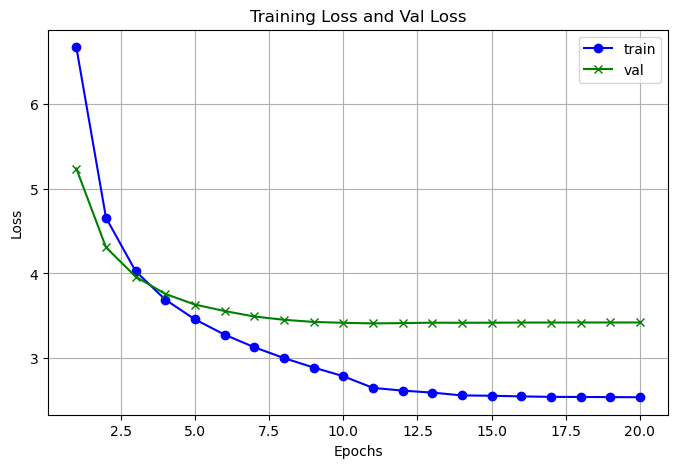

In [58]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,len(train_losses)+1), train_losses,label='train', marker='o', color='blue')
plt.plot(range(1,len(train_losses)+1), val_losses, label='val', marker='x', color='green')
plt.title("Training Loss and Val Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\mikew\AppData\Local\Temp\ipykernel_2716\2580970562.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


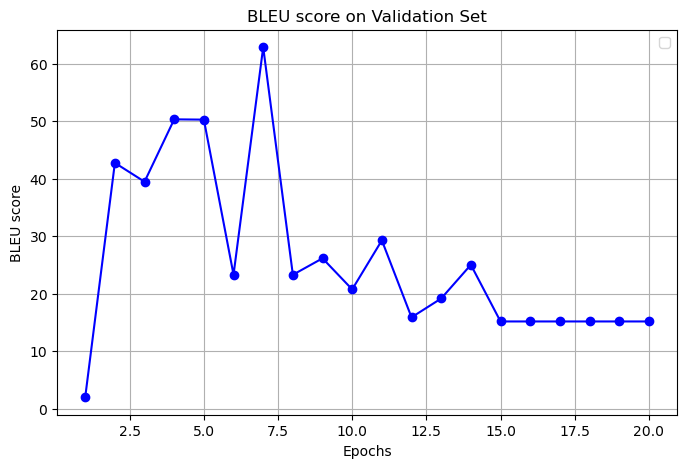

In [59]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,len(train_losses)+1), val_bleu_scores, marker='o', color='blue')
# plt.plot(range(1,len(train_losses)+1), val_losses, label='val', marker='x', color='green')
plt.title("BLEU score on Validation Set")
plt.xlabel('Epochs')
plt.ylabel('BLEU score')
plt.legend()
plt.grid(True)
plt.show()

#### GAT Training

In [60]:
gat_encoder = GAT_Encoder(img_size=224, num_patches=64, use_sin_pe=False)
gat_caption_model = ImageCaptioningModel(encoder=gat_encoder, sin_pe=False)
optimizer_gat = torch.optim.AdamW(gat_caption_model.parameters(), lr=LEARNING_RATE)
model_name = 'gat'

In [61]:

train_losses, val_losses, val_bleu_scores = train_model(gat_caption_model, model_name,train_loader, val_loader,loss_func=loss_func,optimizer=optimizer_gat, epochs=20)

100%|██████████| 127/127 [01:49<00:00,  1.16it/s]


BLEU Score for the model: 1.4763939041893883
best model saved: validation bleu score: 1.4763939041893883
Epoch 1 | Train Loss: 6.6700 | Val Loss: 5.2232 | Val BLEU: 1.4764


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]


BLEU Score for the model: 19.54598432860746
best model saved: validation bleu score: 19.54598432860746
Epoch 2 | Train Loss: 4.6450 | Val Loss: 4.3056 | Val BLEU: 19.5460


100%|██████████| 127/127 [01:48<00:00,  1.17it/s]


BLEU Score for the model: 32.278570333116896
best model saved: validation bleu score: 32.278570333116896
Epoch 3 | Train Loss: 4.0264 | Val Loss: 3.9626 | Val BLEU: 32.2786


100%|██████████| 127/127 [01:48<00:00,  1.17it/s]


BLEU Score for the model: 56.81634942391586
best model saved: validation bleu score: 56.81634942391586
Epoch 4 | Train Loss: 3.6954 | Val Loss: 3.7646 | Val BLEU: 56.8163


100%|██████████| 127/127 [01:46<00:00,  1.19it/s]


BLEU Score for the model: 39.18560278575448
Epoch 5 | Train Loss: 3.4566 | Val Loss: 3.6369 | Val BLEU: 39.1856


100%|██████████| 127/127 [01:46<00:00,  1.19it/s]


BLEU Score for the model: 46.80645369468101
Epoch 6 | Train Loss: 3.2716 | Val Loss: 3.5542 | Val BLEU: 46.8065


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]


BLEU Score for the model: 58.52626113977794
best model saved: validation bleu score: 58.52626113977794
Epoch 7 | Train Loss: 3.1226 | Val Loss: 3.4964 | Val BLEU: 58.5263


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]


BLEU Score for the model: 58.3857408915699
Epoch 8 | Train Loss: 2.9921 | Val Loss: 3.4727 | Val BLEU: 58.3857


100%|██████████| 127/127 [01:48<00:00,  1.18it/s]


BLEU Score for the model: 47.368196987639195
Epoch 9 | Train Loss: 2.8785 | Val Loss: 3.4484 | Val BLEU: 47.3682


100%|██████████| 127/127 [01:48<00:00,  1.17it/s]


BLEU Score for the model: 54.08132478058467
Epoch 10 | Train Loss: 2.7733 | Val Loss: 3.4400 | Val BLEU: 54.0813


100%|██████████| 127/127 [01:48<00:00,  1.17it/s]


BLEU Score for the model: 41.67339720381777
Epoch 11 | Train Loss: 2.6272 | Val Loss: 3.4343 | Val BLEU: 41.6734


100%|██████████| 127/127 [01:49<00:00,  1.16it/s]


BLEU Score for the model: 42.92046192306618
Epoch 12 | Train Loss: 2.5937 | Val Loss: 3.4414 | Val BLEU: 42.9205


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 59.575932042831646
best model saved: validation bleu score: 59.575932042831646
Epoch 13 | Train Loss: 2.5673 | Val Loss: 3.4476 | Val BLEU: 59.5759


100%|██████████| 127/127 [01:49<00:00,  1.15it/s]


BLEU Score for the model: 41.67339720381777
Epoch 14 | Train Loss: 2.5435 | Val Loss: 3.4552 | Val BLEU: 41.6734


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 53.22669065196575
Epoch 15 | Train Loss: 2.5183 | Val Loss: 3.4629 | Val BLEU: 53.2267


100%|██████████| 127/127 [01:48<00:00,  1.17it/s]


BLEU Score for the model: 44.77958781700634
Epoch 16 | Train Loss: 2.4977 | Val Loss: 3.4685 | Val BLEU: 44.7796


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 41.29787352603841
Epoch 17 | Train Loss: 2.4657 | Val Loss: 3.4707 | Val BLEU: 41.2979


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 41.29787352603841
Epoch 18 | Train Loss: 2.4584 | Val Loss: 3.4736 | Val BLEU: 41.2979


100%|██████████| 127/127 [01:47<00:00,  1.18it/s]


BLEU Score for the model: 41.29787352603841
Epoch 19 | Train Loss: 2.4539 | Val Loss: 3.4761 | Val BLEU: 41.2979


100%|██████████| 127/127 [01:41<00:00,  1.25it/s]


BLEU Score for the model: 41.29787352603841
Epoch 20 | Train Loss: 2.4470 | Val Loss: 3.4767 | Val BLEU: 41.2979


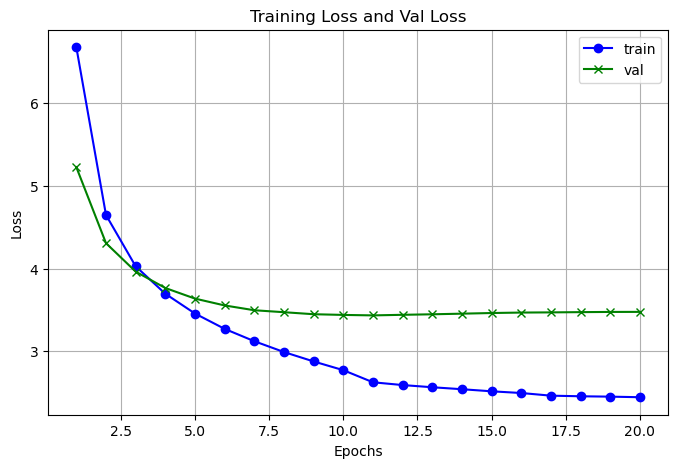

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,len(train_losses)+1), train_losses,label='train', marker='o', color='blue')
plt.plot(range(1,len(train_losses)+1), val_losses, label='val', marker='x', color='green')
plt.title("Training Loss and Val Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\mikew\AppData\Local\Temp\ipykernel_2716\2580970562.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


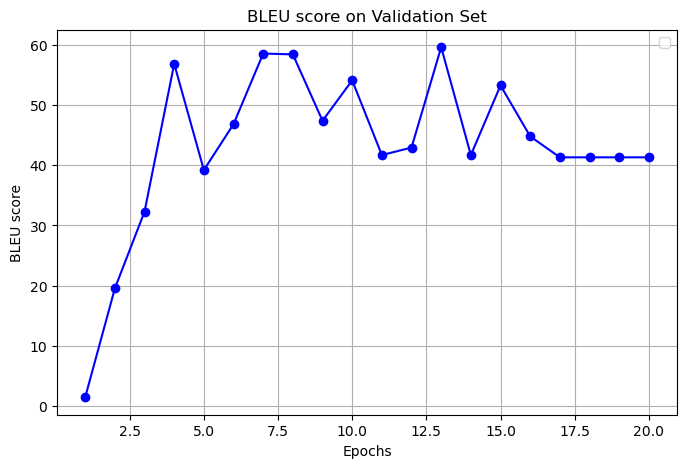

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,len(train_losses)+1), val_bleu_scores, marker='o', color='blue')
# plt.plot(range(1,len(train_losses)+1), val_losses, label='val', marker='x', color='green')
plt.title("BLEU score on Validation Set")
plt.xlabel('Epochs')
plt.ylabel('BLEU score')
plt.legend()
plt.grid(True)
plt.show()

### Train with Full Dataset:
we keep same ratio of validation dataset, so that we can apply scheduler

In [37]:
captions_dict = parse_captions(caption_path)
train_list_full, val_list_full, _ = split_dataset(captions_dict,ratios=(0.8,0.2,0.0))
train_dataset_full = Flickr8kDataset(
        image_path, captions_dict, train_list_full, transform=transform
)
val_dataset_full = Flickr8kDataset(
        image_path, captions_dict, val_list_full, transform=transform
)
train_loader_full = DataLoader(
    train_dataset_full,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
)
val_loader_full = DataLoader(
    val_dataset_full,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

In [38]:
LEARNING_RATE = 2e-4

In [39]:
vit_encoder = ViT_Encoder(img_size=224, num_patches=16, use_sin_pe=False)
vit_caption_model = ImageCaptioningModel(encoder=vit_encoder, sin_pe=False)

optimizer_vit = torch.optim.AdamW(vit_caption_model.parameters(), lr=LEARNING_RATE)

c:\Users\mikew\miniconda3\envs\venv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [40]:
model_name = 'vit_lpe'
train_losses_vit, val_losses_vit, val_bleu_scores_vit = train_model(vit_caption_model, model_name,train_loader_full, val_loader_full,loss_func=loss_func,optimizer=optimizer_vit, epochs=20)

100%|██████████| 127/127 [02:00<00:00,  1.05it/s]


BLEU Score for the model: 23.770841795864293
best model saved: validation bleu score: 23.770841795864293
Epoch 1 | Train Loss: 6.2490 | Val Loss: 4.7815 | Val BLEU: 23.7708


100%|██████████| 127/127 [02:00<00:00,  1.05it/s]


BLEU Score for the model: 19.61887304255142
Epoch 2 | Train Loss: 4.2934 | Val Loss: 4.0674 | Val BLEU: 19.6189


100%|██████████| 127/127 [02:05<00:00,  1.01it/s]


BLEU Score for the model: 57.07286316562615
best model saved: validation bleu score: 57.07286316562615
Epoch 3 | Train Loss: 3.7917 | Val Loss: 3.7769 | Val BLEU: 57.0729


100%|██████████| 127/127 [02:01<00:00,  1.05it/s]


BLEU Score for the model: 30.591118675057672
Epoch 4 | Train Loss: 3.5087 | Val Loss: 3.6151 | Val BLEU: 30.5911


100%|██████████| 127/127 [02:01<00:00,  1.04it/s]


BLEU Score for the model: 37.35249267366084
Epoch 5 | Train Loss: 3.3141 | Val Loss: 3.5102 | Val BLEU: 37.3525


100%|██████████| 127/127 [02:01<00:00,  1.05it/s]


BLEU Score for the model: 42.97792573751152
Epoch 6 | Train Loss: 3.1625 | Val Loss: 3.4495 | Val BLEU: 42.9779


100%|██████████| 127/127 [02:02<00:00,  1.04it/s]


BLEU Score for the model: 27.323698315066235
Epoch 7 | Train Loss: 3.0171 | Val Loss: 3.4213 | Val BLEU: 27.3237


100%|██████████| 127/127 [02:00<00:00,  1.05it/s]


BLEU Score for the model: 48.49517384464982
Epoch 8 | Train Loss: 2.9813 | Val Loss: 3.4143 | Val BLEU: 48.4952


100%|██████████| 127/127 [02:02<00:00,  1.04it/s]


BLEU Score for the model: 30.942856259316038
Epoch 9 | Train Loss: 2.9530 | Val Loss: 3.4087 | Val BLEU: 30.9429


100%|██████████| 127/127 [02:01<00:00,  1.05it/s]


BLEU Score for the model: 30.942856259316038
Epoch 10 | Train Loss: 2.9216 | Val Loss: 3.4050 | Val BLEU: 30.9429


100%|██████████| 127/127 [02:02<00:00,  1.03it/s]


BLEU Score for the model: 36.72201424801275
Epoch 11 | Train Loss: 2.9149 | Val Loss: 3.4044 | Val BLEU: 36.7220


100%|██████████| 127/127 [02:01<00:00,  1.04it/s]


BLEU Score for the model: 48.49517384464982
Epoch 12 | Train Loss: 2.9092 | Val Loss: 3.4040 | Val BLEU: 48.4952


100%|██████████| 127/127 [02:01<00:00,  1.04it/s]


BLEU Score for the model: 48.49517384464982
Epoch 13 | Train Loss: 2.9028 | Val Loss: 3.4038 | Val BLEU: 48.4952


100%|██████████| 127/127 [02:00<00:00,  1.05it/s]


BLEU Score for the model: 48.49517384464982
Epoch 14 | Train Loss: 2.9010 | Val Loss: 3.4036 | Val BLEU: 48.4952


100%|██████████| 127/127 [02:01<00:00,  1.04it/s]


BLEU Score for the model: 48.49517384464982
Epoch 15 | Train Loss: 2.8996 | Val Loss: 3.4035 | Val BLEU: 48.4952


100%|██████████| 127/127 [02:01<00:00,  1.04it/s]


BLEU Score for the model: 48.49517384464982
Epoch 16 | Train Loss: 2.8986 | Val Loss: 3.4034 | Val BLEU: 48.4952


100%|██████████| 127/127 [02:01<00:00,  1.04it/s]


BLEU Score for the model: 48.49517384464982
Epoch 17 | Train Loss: 2.8986 | Val Loss: 3.4034 | Val BLEU: 48.4952


100%|██████████| 127/127 [02:02<00:00,  1.04it/s]


BLEU Score for the model: 48.49517384464982
Epoch 18 | Train Loss: 2.8987 | Val Loss: 3.4034 | Val BLEU: 48.4952


100%|██████████| 127/127 [02:00<00:00,  1.06it/s]


BLEU Score for the model: 48.49517384464982
Epoch 19 | Train Loss: 2.8986 | Val Loss: 3.4034 | Val BLEU: 48.4952


100%|██████████| 127/127 [02:01<00:00,  1.04it/s]


BLEU Score for the model: 48.49517384464982
Epoch 20 | Train Loss: 2.8978 | Val Loss: 3.4034 | Val BLEU: 48.4952


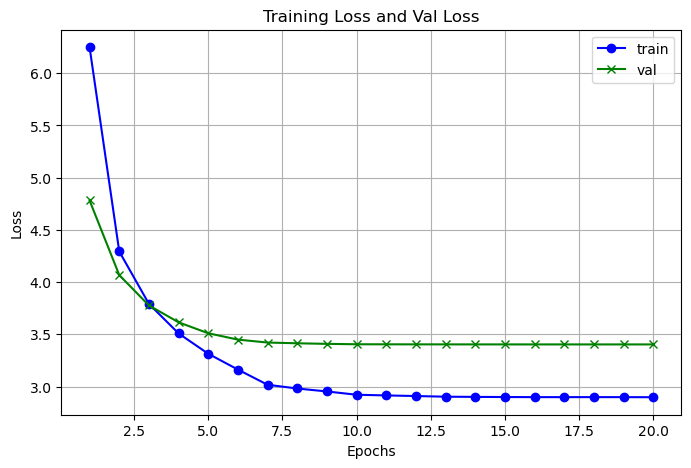

In [42]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,len(train_losses_vit)+1), train_losses_vit,label='train', marker='o', color='blue')
plt.plot(range(1,len(train_losses_vit)+1), val_losses_vit, label='val', marker='x', color='green')
plt.title("Training Loss and Val Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\mikew\AppData\Local\Temp\ipykernel_21400\1576598082.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


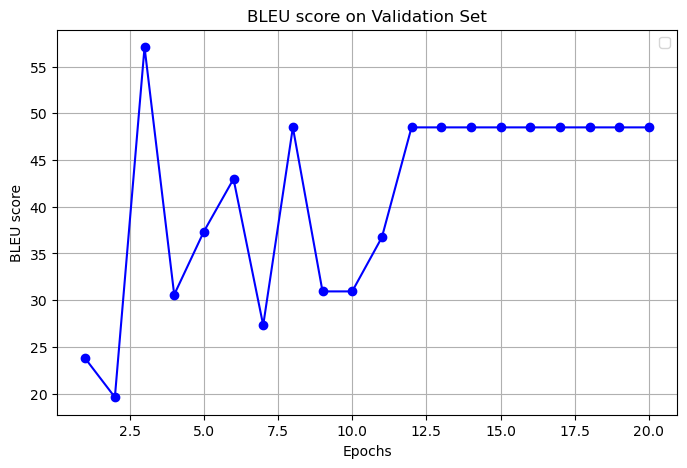

In [43]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,len(train_losses_vit)+1), val_bleu_scores_vit, marker='o', color='blue')
# plt.plot(range(1,len(train_losses)+1), val_losses, label='val', marker='x', color='green')
plt.title("BLEU score on Validation Set")
plt.xlabel('Epochs')
plt.ylabel('BLEU score')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
last_vit_model = vit_caption_model
last_vit_model_path = f'last_model_{model_name}.pth'
torch.save(last_vit_model.state_dict(), last_vit_model_path)

In [45]:
gcn_encoder = GCN_Encoder(img_size=224, num_patches=64, use_sin_pe=False)
gcn_caption_model = ImageCaptioningModel(encoder=gcn_encoder, sin_pe=False)

optimizer_gcn = torch.optim.AdamW(gcn_caption_model.parameters(), lr=LEARNING_RATE)

In [46]:
model_name = 'gcn_lpe'
train_losses_gcn, val_losses_gcn, val_bleu_scores_gcn = train_model(gcn_caption_model,model_name, train_loader_full, val_loader_full,loss_func=loss_func,optimizer=optimizer_gcn, epochs=20)

100%|██████████| 127/127 [01:57<00:00,  1.08it/s]


BLEU Score for the model: 1.4763939041893883
best model saved: validation bleu score: 1.4763939041893883
Epoch 1 | Train Loss: 6.2502 | Val Loss: 4.8073 | Val BLEU: 1.4764


100%|██████████| 127/127 [01:59<00:00,  1.06it/s]


BLEU Score for the model: 49.58012661495252
best model saved: validation bleu score: 49.58012661495252
Epoch 2 | Train Loss: 4.3086 | Val Loss: 4.0660 | Val BLEU: 49.5801


100%|██████████| 127/127 [02:00<00:00,  1.05it/s]


BLEU Score for the model: 44.96214833476127
Epoch 3 | Train Loss: 3.7882 | Val Loss: 3.7613 | Val BLEU: 44.9621


100%|██████████| 127/127 [02:01<00:00,  1.05it/s]


BLEU Score for the model: 46.09765680697782
Epoch 4 | Train Loss: 3.4910 | Val Loss: 3.5847 | Val BLEU: 46.0977


100%|██████████| 127/127 [02:01<00:00,  1.05it/s]


BLEU Score for the model: 60.585266092429194
best model saved: validation bleu score: 60.585266092429194
Epoch 5 | Train Loss: 3.2815 | Val Loss: 3.4757 | Val BLEU: 60.5853


100%|██████████| 127/127 [02:02<00:00,  1.04it/s]


BLEU Score for the model: 54.03367499106635
Epoch 6 | Train Loss: 3.1218 | Val Loss: 3.3992 | Val BLEU: 54.0337


100%|██████████| 127/127 [02:02<00:00,  1.04it/s]


BLEU Score for the model: 39.72104640107055
Epoch 7 | Train Loss: 2.9884 | Val Loss: 3.3539 | Val BLEU: 39.7210


100%|██████████| 127/127 [02:02<00:00,  1.04it/s]


BLEU Score for the model: 23.021861298628863
Epoch 8 | Train Loss: 2.8746 | Val Loss: 3.3208 | Val BLEU: 23.0219


100%|██████████| 127/127 [02:02<00:00,  1.03it/s]


BLEU Score for the model: 40.62344104140848
Epoch 9 | Train Loss: 2.7316 | Val Loss: 3.3035 | Val BLEU: 40.6234


100%|██████████| 127/127 [02:02<00:00,  1.03it/s]


BLEU Score for the model: 23.31397206223232
Epoch 10 | Train Loss: 2.6994 | Val Loss: 3.3029 | Val BLEU: 23.3140


100%|██████████| 127/127 [02:04<00:00,  1.02it/s]


BLEU Score for the model: 22.42220534880427
Epoch 11 | Train Loss: 2.6733 | Val Loss: 3.3014 | Val BLEU: 22.4222


100%|██████████| 127/127 [02:02<00:00,  1.03it/s]


BLEU Score for the model: 22.42220534880427
Epoch 12 | Train Loss: 2.6400 | Val Loss: 3.3006 | Val BLEU: 22.4222


100%|██████████| 127/127 [02:01<00:00,  1.04it/s]


BLEU Score for the model: 22.42220534880427
Epoch 13 | Train Loss: 2.6335 | Val Loss: 3.3009 | Val BLEU: 22.4222


100%|██████████| 127/127 [02:06<00:00,  1.01it/s]


BLEU Score for the model: 40.62344104140848
Epoch 14 | Train Loss: 2.6296 | Val Loss: 3.3011 | Val BLEU: 40.6234


100%|██████████| 127/127 [02:03<00:00,  1.03it/s]


BLEU Score for the model: 44.73912374795749
Epoch 15 | Train Loss: 2.6217 | Val Loss: 3.3014 | Val BLEU: 44.7391


100%|██████████| 127/127 [02:03<00:00,  1.03it/s]


BLEU Score for the model: 44.73912374795749
Epoch 16 | Train Loss: 2.6213 | Val Loss: 3.3014 | Val BLEU: 44.7391


100%|██████████| 127/127 [02:03<00:00,  1.03it/s]


BLEU Score for the model: 44.73912374795749
Epoch 17 | Train Loss: 2.6205 | Val Loss: 3.3017 | Val BLEU: 44.7391


100%|██████████| 127/127 [02:01<00:00,  1.04it/s]


BLEU Score for the model: 44.73912374795749
Epoch 18 | Train Loss: 2.6173 | Val Loss: 3.3017 | Val BLEU: 44.7391


100%|██████████| 127/127 [02:02<00:00,  1.04it/s]


BLEU Score for the model: 44.73912374795749
Epoch 19 | Train Loss: 2.6192 | Val Loss: 3.3018 | Val BLEU: 44.7391


100%|██████████| 127/127 [02:12<00:00,  1.04s/it]


BLEU Score for the model: 44.73912374795749
Epoch 20 | Train Loss: 2.6183 | Val Loss: 3.3018 | Val BLEU: 44.7391


In [47]:
last_model_gcn = gcn_caption_model
last_model_gcn_path = f'last_model_{model_name}.pth'
torch.save(last_model_gcn.state_dict(), last_model_gcn_path)

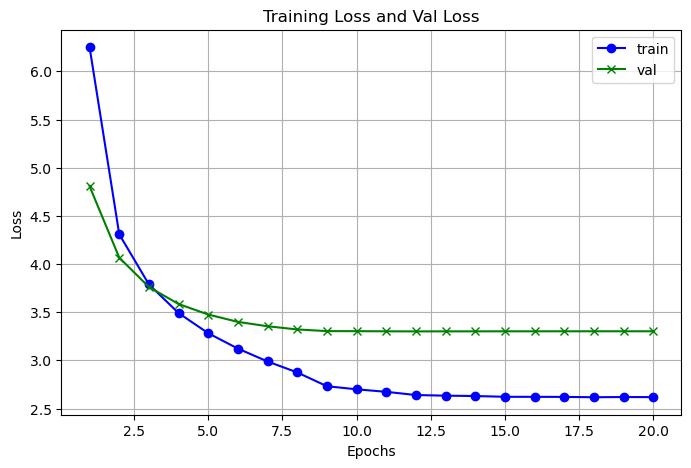

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,len(train_losses_gcn)+1), train_losses_gcn,label='train', marker='o', color='blue')
plt.plot(range(1,len(train_losses_gcn)+1), val_losses_gcn, label='val', marker='x', color='green')
plt.title("Training Loss and Val Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\mikew\AppData\Local\Temp\ipykernel_21400\1080018608.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


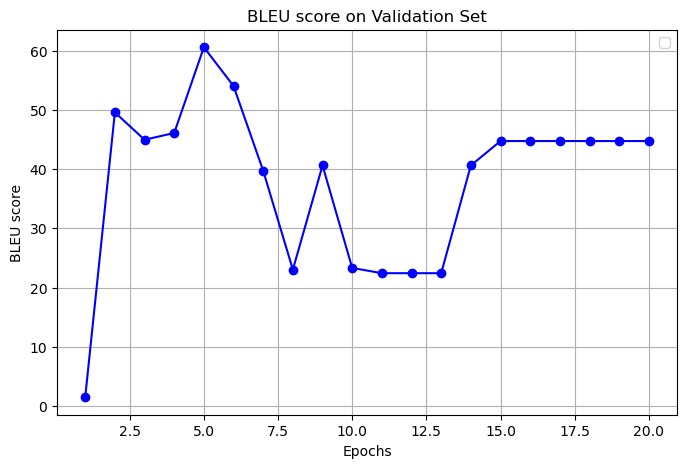

In [49]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,len(train_losses_gcn)+1), val_bleu_scores_gcn, marker='o', color='blue')
# plt.plot(range(1,len(train_losses)+1), val_losses, label='val', marker='x', color='green')
plt.title("BLEU score on Validation Set")
plt.xlabel('Epochs')
plt.ylabel('BLEU score')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
gat_encoder = GAT_Encoder(img_size=224, num_patches=64, use_sin_pe=False)
gat_caption_model = ImageCaptioningModel(encoder=gat_encoder, sin_pe=False)
optimizer_gat = torch.optim.AdamW(gat_caption_model.parameters(), lr=LEARNING_RATE)

In [51]:
model_name = 'gat_lpe'
train_losses_gat, val_losses_gat, val_bleu_scores_gat = train_model(gat_caption_model,model_name, train_loader_full, val_loader_full,loss_func=loss_func,optimizer=optimizer_gat, epochs=20)

100%|██████████| 127/127 [02:09<00:00,  1.02s/it]


BLEU Score for the model: 14.75802991962099
best model saved: validation bleu score: 14.75802991962099
Epoch 1 | Train Loss: 6.2478 | Val Loss: 4.8086 | Val BLEU: 14.7580


100%|██████████| 127/127 [02:17<00:00,  1.08s/it]


BLEU Score for the model: 33.85463794109317
best model saved: validation bleu score: 33.85463794109317
Epoch 2 | Train Loss: 4.3060 | Val Loss: 4.0701 | Val BLEU: 33.8546


100%|██████████| 127/127 [02:10<00:00,  1.03s/it]


BLEU Score for the model: 25.055235392515165
Epoch 3 | Train Loss: 3.7856 | Val Loss: 3.7602 | Val BLEU: 25.0552


100%|██████████| 127/127 [02:07<00:00,  1.00s/it]


BLEU Score for the model: 58.309436122725884
best model saved: validation bleu score: 58.309436122725884
Epoch 4 | Train Loss: 3.4869 | Val Loss: 3.5831 | Val BLEU: 58.3094


100%|██████████| 127/127 [02:11<00:00,  1.04s/it]


BLEU Score for the model: 51.0868636959402
Epoch 5 | Train Loss: 3.2753 | Val Loss: 3.4718 | Val BLEU: 51.0869


100%|██████████| 127/127 [02:09<00:00,  1.02s/it]


BLEU Score for the model: 42.331456979365555
Epoch 6 | Train Loss: 3.1120 | Val Loss: 3.3957 | Val BLEU: 42.3315


100%|██████████| 127/127 [02:09<00:00,  1.02s/it]


BLEU Score for the model: 43.29051306333389
Epoch 7 | Train Loss: 2.9747 | Val Loss: 3.3538 | Val BLEU: 43.2905


100%|██████████| 127/127 [02:10<00:00,  1.03s/it]


BLEU Score for the model: 48.33652742632928
Epoch 8 | Train Loss: 2.8221 | Val Loss: 3.3372 | Val BLEU: 48.3365


100%|██████████| 127/127 [02:16<00:00,  1.08s/it]


BLEU Score for the model: 29.49146879373058
Epoch 9 | Train Loss: 2.7835 | Val Loss: 3.3345 | Val BLEU: 29.4915


100%|██████████| 127/127 [02:12<00:00,  1.04s/it]


BLEU Score for the model: 41.329755277612854
Epoch 10 | Train Loss: 2.7541 | Val Loss: 3.3339 | Val BLEU: 41.3298


100%|██████████| 127/127 [02:11<00:00,  1.03s/it]


BLEU Score for the model: 41.329755277612854
Epoch 11 | Train Loss: 2.7185 | Val Loss: 3.3332 | Val BLEU: 41.3298


100%|██████████| 127/127 [02:17<00:00,  1.08s/it]


BLEU Score for the model: 31.572381578463872
Epoch 12 | Train Loss: 2.7119 | Val Loss: 3.3335 | Val BLEU: 31.5724


100%|██████████| 127/127 [02:05<00:00,  1.01it/s]


BLEU Score for the model: 41.329755277612854
Epoch 13 | Train Loss: 2.7059 | Val Loss: 3.3350 | Val BLEU: 41.3298


100%|██████████| 127/127 [02:05<00:00,  1.01it/s]


BLEU Score for the model: 41.329755277612854
Epoch 14 | Train Loss: 2.6977 | Val Loss: 3.3346 | Val BLEU: 41.3298


100%|██████████| 127/127 [02:06<00:00,  1.00it/s]


BLEU Score for the model: 41.329755277612854
Epoch 15 | Train Loss: 2.6966 | Val Loss: 3.3348 | Val BLEU: 41.3298


100%|██████████| 127/127 [02:06<00:00,  1.01it/s]


BLEU Score for the model: 41.329755277612854
Epoch 16 | Train Loss: 2.6954 | Val Loss: 3.3350 | Val BLEU: 41.3298


100%|██████████| 127/127 [02:05<00:00,  1.01it/s]


BLEU Score for the model: 41.329755277612854
Epoch 17 | Train Loss: 2.6939 | Val Loss: 3.3350 | Val BLEU: 41.3298


100%|██████████| 127/127 [02:05<00:00,  1.01it/s]


BLEU Score for the model: 41.329755277612854
Epoch 18 | Train Loss: 2.6940 | Val Loss: 3.3350 | Val BLEU: 41.3298


100%|██████████| 127/127 [02:05<00:00,  1.01it/s]


BLEU Score for the model: 41.329755277612854
Epoch 19 | Train Loss: 2.6933 | Val Loss: 3.3351 | Val BLEU: 41.3298


100%|██████████| 127/127 [02:11<00:00,  1.04s/it]


BLEU Score for the model: 41.329755277612854
Epoch 20 | Train Loss: 2.6933 | Val Loss: 3.3351 | Val BLEU: 41.3298


In [52]:
last_model_gat = gat_caption_model
last_model_gat_path = f'last_model_{model_name}.pth'
torch.save(last_model_gat.state_dict(), last_model_gat_path)

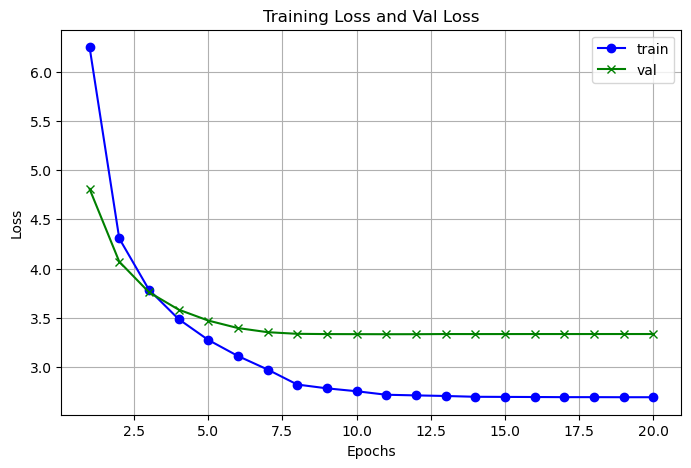

In [53]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,len(train_losses_gat)+1), train_losses_gat,label='train', marker='o', color='blue')
plt.plot(range(1,len(train_losses_gat)+1), val_losses_gat, label='val', marker='x', color='green')
plt.title("Training Loss and Val Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\mikew\AppData\Local\Temp\ipykernel_21400\393218384.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


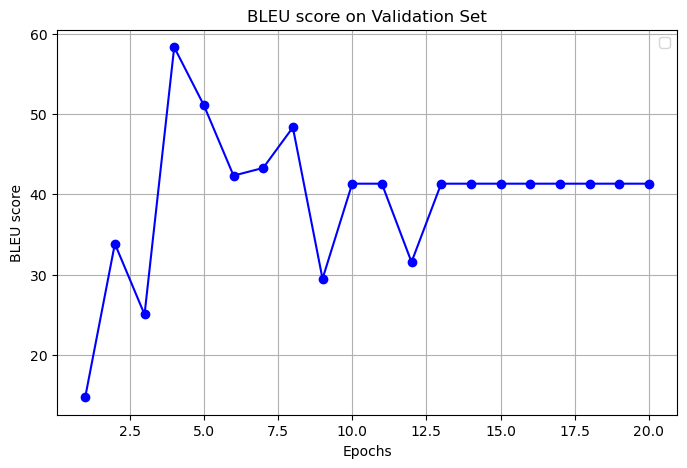

In [54]:
plt.figure(figsize=(8, 5))
plt.plot(range(1,len(train_losses_gat)+1), val_bleu_scores_gat, marker='o', color='blue')
# plt.plot(range(1,len(train_losses)+1), val_losses, label='val', marker='x', color='green')
plt.title("BLEU score on Validation Set")
plt.xlabel('Epochs')
plt.ylabel('BLEU score')
plt.legend()
plt.grid(True)
plt.show()

## Evaluateing model

### Test on COCO dataset

In [55]:
# load vit model
vit_model_path_best = 'best_model_vit_lpe.pth'
vit_model_path_last = last_vit_model_path
vit_encoder_best = ViT_Encoder(img_size=224, num_patches=16, use_sin_pe=False)
vit_caption_model_best = ImageCaptioningModel(vit_encoder_best, sin_pe=False)
vit_encoder_last = ViT_Encoder(img_size=224, num_patches=16, use_sin_pe=False)
vit_caption_model_last = ImageCaptioningModel(vit_encoder_last, sin_pe=False)

vit_caption_model_best.load_state_dict(torch.load(vit_model_path_best))
vit_caption_model_last.load_state_dict(torch.load(vit_model_path_last))

vit_caption_model_best.to(device)
vit_caption_model_last.to(device)


c:\Users\mikew\miniconda3\envs\venv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\mikew\AppData\Local\Temp\ipykernel_21400\2683155048.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seriali

ImageCaptioningModel(
  (encoder): ViT_Encoder(
    (patch_embedding): Linear(in_features=9408, out_features=128, bias=True)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-11): 12 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (encoder_proj): Linear(in_features=128, out_features=128, bias=True)
  (token_embedding): Embedding(50257, 128)
  (position_

In [62]:
test_bleu_vit_best = evaluateBLEU(vit_caption_model_best,coco_test_loader)
test_bleu_vit_last = evaluateBLEU(vit_caption_model_last,coco_test_loader)

if test_bleu_vit_best> test_bleu_vit_last:
    print(f"bleu score for coco test dataset is: {test_bleu_vit_best}, it is the best saved model")
else:
    print(f"bleu score for coco test dataset is: {test_bleu_vit_last}, it is the last saved model")

100%|██████████| 633/633 [16:18<00:00,  1.55s/it]


BLEU Score for the model: 58.233097125860304


100%|██████████| 633/633 [13:26<00:00,  1.27s/it]


BLEU Score for the model: 42.1441947026684
bleu score for coco test dataset is: 58.233097125860304, it is the best saved model


In [63]:
# load gcn model
gcn_model_path_best = 'best_model_gcn_lpe.pth'
gcn_model_path_last = last_model_gcn_path
gcn_encoder_best = GCN_Encoder(img_size=224, num_patches=64, use_sin_pe=False)
gcn_caption_model_best = ImageCaptioningModel(gcn_encoder_best, sin_pe=False)
gcn_encoder_last = GCN_Encoder(img_size=224, num_patches=64, use_sin_pe=False)
gcn_caption_model_last = ImageCaptioningModel(gcn_encoder_last, sin_pe=False)

gcn_caption_model_best.load_state_dict(torch.load(gcn_model_path_best))
gcn_caption_model_last.load_state_dict(torch.load(gcn_model_path_last))

gcn_caption_model_best.to(device)
gcn_caption_model_last.to(device)


C:\Users\mikew\AppData\Local\Temp\ipykernel_21400\2631215339.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn_caption_model_best.load_state_dict(torch.load(gcn_model_

ImageCaptioningModel(
  (encoder): GCN_Encoder(
    (patch_embed): Linear(in_features=2352, out_features=128, bias=True)
    (convs): ModuleList(
      (0-2): 3 x GCNConv(128, 128)
    )
    (proj_out): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_proj): Linear(in_features=128, out_features=128, bias=True)
  (token_embedding): Embedding(50257, 128)
  (position_encoding): Embedding(30, 128)
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features

In [64]:
test_bleu_gcn_best = evaluateBLEU(gcn_caption_model_best,coco_test_loader)
test_bleu_gcn_last = evaluateBLEU(gcn_caption_model_last,coco_test_loader)

if test_bleu_gcn_best> test_bleu_gcn_last:
    print(f"bleu score for coco test dataset is: {test_bleu_gcn_best}, it is the best saved model")
else:
    print(f"bleu score for coco test dataset is: {test_bleu_gcn_last}, it is the last saved model")

100%|██████████| 633/633 [13:14<00:00,  1.26s/it]


BLEU Score for the model: 67.11661134274713


100%|██████████| 633/633 [14:34<00:00,  1.38s/it]


BLEU Score for the model: 45.692348745151406
bleu score for coco test dataset is: 67.11661134274713, it is the best saved model


In [65]:
# load gcn model
gat_model_path_best = 'best_model_gat_lpe.pth'
gat_model_path_last = last_model_gat_path
gat_encoder_best = GAT_Encoder(img_size=224, num_patches=64, use_sin_pe=False)
gat_caption_model_best = ImageCaptioningModel(gat_encoder_best, sin_pe=False)
gat_encoder_last = GAT_Encoder(img_size=224, num_patches=64, use_sin_pe=False)
gat_caption_model_last = ImageCaptioningModel(gat_encoder_last, sin_pe=False)

gat_caption_model_best.load_state_dict(torch.load(gat_model_path_best))
gat_caption_model_last.load_state_dict(torch.load(gat_model_path_last))

gat_caption_model_best.to(device)
gat_caption_model_last.to(device)


C:\Users\mikew\AppData\Local\Temp\ipykernel_21400\3002723490.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gat_caption_model_best.load_state_dict(torch.load(gat_model_

ImageCaptioningModel(
  (encoder): GAT_Encoder(
    (patch_embed): Linear(in_features=2352, out_features=128, bias=True)
    (convs): ModuleList(
      (0-2): 3 x GATConv(128, 128, heads=1)
    )
    (proj_out): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_proj): Linear(in_features=128, out_features=128, bias=True)
  (token_embedding): Embedding(50257, 128)
  (position_encoding): Embedding(30, 128)
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out

In [66]:
test_bleu_gat_best = evaluateBLEU(gat_caption_model_best,coco_test_loader)
test_bleu_gat_last = evaluateBLEU(gat_caption_model_last,coco_test_loader)

if test_bleu_gat_best> test_bleu_gat_last:
    print(f"bleu score for coco test dataset is: {test_bleu_gat_best}, it is the best saved model")
else:
    print(f"bleu score for coco test dataset is: {test_bleu_gat_last}, it is the last saved model")

100%|██████████| 633/633 [15:35<00:00,  1.48s/it]


BLEU Score for the model: 64.28416567031141


100%|██████████| 633/633 [15:46<00:00,  1.50s/it]


BLEU Score for the model: 29.815564924567646
bleu score for coco test dataset is: 64.28416567031141, it is the best saved model


### Test on Flicker8k test set

In [64]:
# load the best model
best_encoder = GCN_Encoder(img_size=224, num_patches=64, use_sin_pe=False)
best_model_gcn = ImageCaptioningModel(best_encoder, sin_pe=False)

best_model_gcn.load_state_dict(torch.load('best_model_gcn.pth'))
best_model_gcn.to(device)


C:\Users\mikew\AppData\Local\Temp\ipykernel_2716\1418581433.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_gcn.load_state_dict(torch.load('best_model_gcn.pth

ImageCaptioningModel(
  (encoder): GCN_Encoder(
    (patch_embed): Linear(in_features=2352, out_features=128, bias=True)
    (convs): ModuleList(
      (0-2): 3 x GCNConv(128, 128)
    )
    (proj_out): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_proj): Linear(in_features=128, out_features=128, bias=True)
  (token_embedding): Embedding(50257, 128)
  (position_encoding): Embedding(30, 128)
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features

In [65]:
test_bleu = evaluateBLEU(best_model_gcn,test_loader)

print(f"bleu score for test dataset is: {test_bleu}")

100%|██████████| 127/127 [01:53<00:00,  1.12it/s]


BLEU Score for the model: 19.095230982774122
bleu score for test dataset is: 19.095230982774122


In [66]:
best_encoder = GAT_Encoder(img_size=224, num_patches=64, use_sin_pe=False)
best_model_gat = ImageCaptioningModel(best_encoder, sin_pe=False)

best_model_gat.load_state_dict(torch.load('best_model_gat.pth'))
best_model_gat.to(device)

C:\Users\mikew\AppData\Local\Temp\ipykernel_2716\884203810.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_gat.load_state_dict(torch.load('best_model_gat.pth'

ImageCaptioningModel(
  (encoder): GAT_Encoder(
    (patch_embed): Linear(in_features=2352, out_features=128, bias=True)
    (convs): ModuleList(
      (0-2): 3 x GATConv(128, 128, heads=1)
    )
    (proj_out): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_proj): Linear(in_features=128, out_features=128, bias=True)
  (token_embedding): Embedding(50257, 128)
  (position_encoding): Embedding(30, 128)
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out

In [67]:
test_bleu = evaluateBLEU(best_model_gat,test_loader)

print(f"bleu score for test dataset is: {test_bleu}")

100%|██████████| 127/127 [01:53<00:00,  1.12it/s]


BLEU Score for the model: 31.988083864647407
bleu score for test dataset is: 31.988083864647407


In [68]:
best_encoder = ViT_Encoder(img_size=224, num_patches=16, use_sin_pe=False)
best_model_vit = ImageCaptioningModel(best_encoder, sin_pe=False)

best_model_vit.load_state_dict(torch.load('best_model_VIT.pth'))
best_model_vit.to(device)

c:\Users\mikew\miniconda3\envs\venv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
C:\Users\mikew\AppData\Local\Temp\ipykernel_2716\3855290756.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializ

ImageCaptioningModel(
  (encoder): ViT_Encoder(
    (patch_embedding): Linear(in_features=9408, out_features=128, bias=True)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-11): 12 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (encoder_proj): Linear(in_features=128, out_features=128, bias=True)
  (token_embedding): Embedding(50257, 128)
  (position_

In [69]:
test_bleu = evaluateBLEU(best_model_vit,test_loader)

print(f"bleu score for test dataset is: {test_bleu}")

100%|██████████| 127/127 [01:46<00:00,  1.20it/s]


BLEU Score for the model: 35.76495594335127
bleu score for test dataset is: 35.76495594335127


In [70]:
print(len(train_dataset))

24270


## Draw the Results Plot

In [ ]:
# this is tested on flicker8k test set
gcn_lpe = 19.23
gcn_sinpe = 50.72
gat_sinpe = 46.56
gat_lpe = 32.63
vit_sinpe = 44.17
vit_lpe = 35.49


In [ ]:
# this is on coco dataset
gcn_sinpe = 57.74
gcn_lpe = 67.12
gat_sinpe = 77.57
gat_lpe = 64.28
vit_sinpe = 68.54
vit_lpe = 58.23


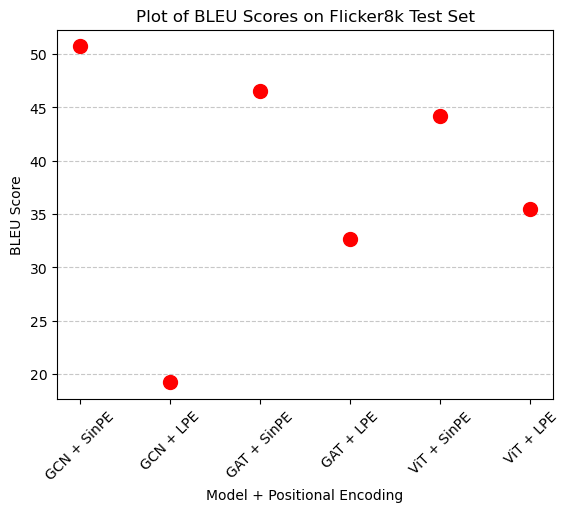

In [2]:
import matplotlib.pyplot as plt

# Model labels
models = ['GCN + SinPE', 'GCN + LPE', 'GAT + SinPE', 'GAT + LPE', 'ViT + SinPE', 'ViT + LPE']

# BLEU scores
flicker8k_values = [50.72, 19.23, 46.56, 32.63, 44.17, 35.49]
coco_values = [57.74, 67.12, 77.57, 64.28, 68.54, 58.23]



# Restored Dot Plot
plt.plot(models, flicker8k_values, 'o', markersize=10, color='red')
plt.title('Plot of BLEU Scores on Flicker8k Test Set')
plt.xlabel('Model + Positional Encoding')
plt.ylabel('BLEU Score')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='x', rotation=45)

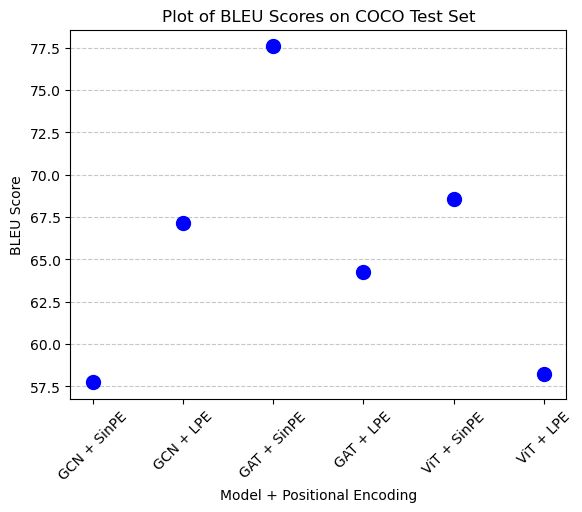

In [3]:
plt.plot(models, coco_values, 'o', markersize=10, color='blue')
plt.title('Plot of BLEU Scores on COCO Test Set')
plt.xlabel('Model + Positional Encoding')
plt.ylabel('BLEU Score')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tick_params(axis='x', rotation=45)